<a href="https://colab.research.google.com/github/aquapathos/BasicAI/blob/master/IAI_3_2_%E6%B1%BA%E5%AE%9A%E6%9C%A8%E3%81%AE%E5%AD%A6%E7%BF%92_2_%E3%82%BF%E3%82%A4%E3%82%BF%E3%83%8B%E3%83%83%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

まず、必要なライブラリを読み込んでおきます。実行は1度だけでOK

In [1]:
# モジュールのインポート
!apt-get -qq -y install fonts-ipafont-gothic > /dev/null
import pandas as pd
import numpy as np
from sklearn import tree
from graphviz import Digraph,Source
import pydotplus as pdp

## 準備　データファイルのアップロード

次のセルを実行して、
配布されているファイル "**titanic.xlsx**" をアップロードしてください。

左のエリアにドラッグ＆ドロップでも構いません。





In [2]:
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

Saving titanic.xlsx to titanic.xlsx


In [3]:
# エクセルファイルの読み込み
train = pd.read_excel('titanic.xlsx')
train.drop(['氏名'],axis=1,inplace=True) # 氏名欄を除去

DSTART=0     # 訓練に使うデータの開始番号
DNUMBER=16   # 訓練データの個数
DEND=DSTART+DNUMBER

# 例に使うデータの取り出し
y = train['生死'].iloc[DSTART:DEND].copy()    # 正解データ
X = train.drop('生死',axis=1).iloc[DSTART:DEND].copy()  # 訓練用データ ('生死'以外の情報)

print('生死は１:生存, ０:死亡、性別は１:男性, 0：女性:')

cindex = X.columns # 生死の決め手となる可能性のある属性
# データの確認
train.iloc[DSTART:DEND]

生死は１:生存, ０:死亡、性別は１:男性, 0：女性:


,生死,船室等級,性別,年齢,子供の数,大人の数,船賃
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500
5,0,3,1,27.0,0,0,8.4583
6,0,1,1,54.0,0,0,51.8625
7,0,3,1,2.0,3,1,21.0750
8,1,3,0,27.0,0,2,11.1333
9,1,2,0,14.0,1,0,30.0708


# 情報量基準による決定木の生成

試しに、上の16名の犠牲者のデータの生死を分けた決定木を生成してみましょう。

In [4]:
# 決定木の学習　（entropy => 情報量基準）
clf = tree.DecisionTreeClassifier(max_depth=4,criterion='entropy')
clf.fit(X, y);

# プログラム解説
２行目の、criterion='entropy' で、決定木を作成する基準がエントロピー、すなわち情報量基準であることを指定しています。

## 決定木の保存と図示

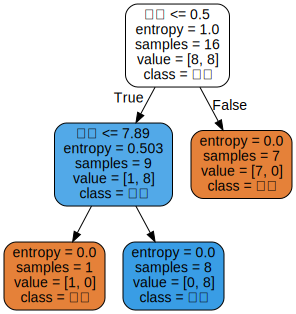

In [5]:
# 決定木の描画用データ dot_data を生成する
dot_data = tree.export_graphviz(clf, 
            out_file=None, # 出力ファイル名 None なら出力しない
            filled=True, # ノードを色づけする
            rounded=True, # ノードの角を丸く
            class_names=['死亡','生存'],
            feature_names=cindex) 

# 画像の保存
graph = pdp.graph_from_dot_data(dot_data)
for node in graph.get_nodes():
    node.set_fontname("IPAGothic")
graph.write_png("タイタニック号最初の16人の生死の決定木.png")

# 決定木の表示
Source(dot_data)

（注）上に表示されている画像は右クリップでの保存ができません。レポートに図を使いたい場合は、左のエリアに保存されているファイルを使ってください。

# 補足
(1) 性別は０が女性、１が男性なので、最初のテスト「性別 ≦ 0.5」は男女の振り分けを意味します。女性の場合は左の枝へ、男性の場合は右の枝へ進むことになります。  
(2) 次は船賃が 7.89 より低ければ左、高ければ右です。

# 結果について

先頭から１６人について言えることでしかありませんが、

1. まず性別で振り分けると、16人中7人が男性で、全員死亡（最初の右の枝）
2. 女性（左の枝）は、船賃が安かった人（２段目左の枝）１人だけ死亡、残り８人（右の枝）は生存

という結果でした。

## 学習と評価の関数化

In [6]:
# 一部を学習に用いて作った決定木で別のデータを分別する
def ds_predict(DSTART=0,DNUMBER=16,TSTART=0,TNUMBER=16,max_depth=3,showresult=True):
  # DSTART   訓練に使うデータの開始番号
  # DNUMBER  訓練に使うデータ数
  # TSTART   テストに使うデータの開始番号
  # TNUMBER  テストに使うデータ数
  DEND=DSTART+DNUMBER
  TEND=TSTART+TNUMBER

  # 例に使うデータの取り出し
  y = train['生死'].iloc[DSTART:DEND].copy()    # 正解データ
  X = train.drop('生死',axis=1).iloc[DSTART:DEND].copy()  # 訓練用データ ('生死'以外の情報)
  cindex = X.columns # 生死の決め手となる可能性のある属性

  # 決定木の学習　（entropy => 情報量基準）
  clf = tree.DecisionTreeClassifier(max_depth=max_depth,criterion='entropy')
  clf.fit(X, y)

  # テストデータの抽出
  T = train.iloc[TSTART:TEND].copy()  
  # 生死予測
  T['生死予測']=clf.predict(T[cindex])

  dead = T[T['生死'] == 0] # テストデータ中の死者データ
  survivor = T[T['生死'] == 1] # テストデータ中の生存者データ
  n_dead = len(dead) # テストデータ中の死者数
  n_survivor = len(survivor) # テストデータ中の生存者数

  n_correct = (T['生死'] == T['生死予測']).value_counts()[True] # 全データ中の正解数
  n_dcorrect = (dead['生死予測']==0).value_counts()[True]
  n_scorrect = (survivor['生死予測']==1).value_counts()[True]

  if showresult:
      print(f"訓練データは{DSTART}番から{DNUMBER}個")
      print(f"テストデータは{TSTART}番から{TNUMBER}個")
      print("全正解率 {:3.2f}％".format(n_correct*100/len(T)))
      print("死者{}名中、正しく予想した割合は {:3.2f}％".format(n_dead,n_dcorrect*100/n_dead))
      print("生存者{}名中、正しく予想した割合は {:3.2f}％".format(n_survivor,n_scorrect*100/n_survivor))

  return clf,n_correct/len(T)

# 決定木の描画と保存
def showtree(clf,saveimg=False,filename="dtree"):
    # 決定木の描画用データ dot_data を生成する
    dot_data = tree.export_graphviz(clf, 
                out_file=None, # 出力ファイル名 None なら出力しない
                filled=True, # ノードを色づけする
                rounded=True, # ノードの角を丸く
                class_names=['死亡','生存'],
                feature_names=cindex) 

    # 画像の保存
    if saveimg:
        graph = pdp.graph_from_dot_data(dot_data)
        for node in graph.get_nodes():
            node.set_fontname("IPAGothic")
        graph.write_png(filename+".png")

    # 決定木の表示
    return Source(dot_data)

# 関数の解説

## **ds_predict()**　決定木の学習と評価

```
ds_predict(DSTART=0,DNUMBER=16,TSTART=0,TNUMBER=16,max_depth=3,showresult=True)
```

### **パラメータ**
- **DSTART** 番目から **DNUMBER** 個のデータを訓練データとする。   
- **TSTART** 番目から **TNUMBER** 個のデータを評価用データとする。 
- **max_depth** 決定木の最大の深さ　デフォルトは3   
- **showresult** 結果を表示するかどうか。

### **返り値**
- **clf** 決定木   
- **c** 正解率

## **showtree()**　決定木の描画

```
showtree(clf,saveimg=False,filename="dtree")
```
### **パラメータ**
- **clf** 識別器(決定木)   
- **saveimg** 決定木の画像を保存するかいなか。   
- **filename** 保存する場合のファイル名

# 実行例

33番のデータから100個を訓練例として使って決定木を作成し、同じデータを使って検証してみます。



In [7]:
clf,c = ds_predict(DSTART=33,DNUMBER=100,TSTART=33,TNUMBER=100,max_depth=3,showresult=True)

訓練データは33番から100個
テストデータは33番から100個
全正解率 86.00％
死者68名中、正しく予想した割合は 97.06％
生存者32名中、正しく予想した割合は 62.50％


できた決定木を描画します。

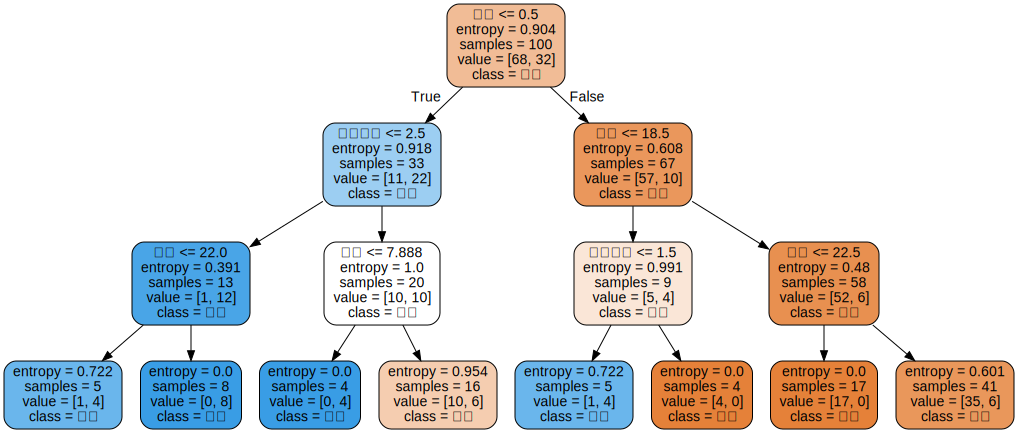

In [8]:
showtree(clf,saveimg=True,filename="dtree")

訓練例そのもので評価していますが、正解率は86％しかありません。これは最初の例がデータ16個であったのに対し、データが100と増えており、決定木の段数を３段に制限しているためです。

決定木を見ると、一番下のノードでも、value が[1,4],[10,6]のように、片方が０とはなっていません。つまり、下まできても生存例と死亡例が混在するということです。

つまり、タイタニック号の悲劇での生死の分かれ目は３つの条件程度では決められないわけです。

上の決定木の概要をまとめておきます。 
(1段目)まず性別で男女に分ける。   
(2段目左)左は女性ですが、女性は33人うち11人死亡22人生存です。女性の場合は、船室等級を判定、１，２等は左の枝、２等船室は右。   
(3段目1）女性で１か２等船室の場合です。この場合、最後に船賃が22以下かそうでないかで分かれます。22以下の場合は生存者４、死者１で、生死は確定しません。あえて推測を求められれば、生存と答えることになります。   
(3段目2）女性で３等船室の場合です。船賃が 7.88 をしきい値として少ないか多いかで振り分けです。7.88 以下の人は生存確定。それを超える場合は、死亡例が10、生存例が６。敢えてどちらかと言えば、死亡となります。      
(2段目右）右は男性の場合です。男性はまず、年齢が18歳以下か19歳以上かでわけます。    
(3段目3）男性で18歳以下の場合です。この場合、同室の子供が１以下か2以上かでわけます。1以下の場合は５例あり、内４例は生存ですので、生存確率が高い。子供が２以上の場合は４例あり、皆死亡です。男性で18歳以下、子供の数が多い場合は死亡という判定となります。    
(3段目4）男性で19歳以上の場合、さらに年齢で、22歳までと23歳以上とに分けます。22歳まで、つまり、19歳～22歳の男性は全員死亡。23歳以上の男性は41人中35人が死亡、6人が生存でした。   
結局男性はほとんど死亡で、生存と判定されるのは、18歳以下で子供がいないか1人の場合だけになります。


試しに max_depth をもっと増やしてみましょう。

In [13]:
clf,c = ds_predict(DSTART=0,DNUMBER=400,TSTART=0,TNUMBER=400,showresult=True,max_depth=15)

訓練データは0番から400個
テストデータは0番から400個
全正解率 95.50％
死者242名中、正しく予想した割合は 100.00％
生存者158名中、正しく予想した割合は 88.61％


15段で死者に関しては100％、生存者は9割近い正解率となりました。

同じ訓練データで、未知データである400番以降400人の生死予測をしてみます。

In [14]:
clf,c = ds_predict(DSTART=0,DNUMBER=400,TSTART=400,TNUMBER=400,showresult=True,max_depth=15)

訓練データは0番から400個
テストデータは400番から400個
全正解率 76.25％
死者247名中、正しく予想した割合は 82.19％
生存者153名中、正しく予想した割合は 66.67％


同じ訓練データ、テストデータで、max_depth=3 としてみます。

In [15]:
clf,c = ds_predict(DSTART=0,DNUMBER=400,TSTART=400,TNUMBER=400,showresult=True,max_depth=3)

訓練データは0番から400個
テストデータは400番から400個
全正解率 78.25％
死者247名中、正しく予想した割合は 87.45％
生存者153名中、正しく予想した割合は 63.40％


16段の決定木よりも、3段の決定木の方が勝るという不思議な結果となります。

訓練データとテストデータが別の場合、こういうことが起こるのは不思議ではありません。これは、16段では訓練データに**オーバフィッティング**している、**過学習**が起こっているということです。

# 課題

- DSTART=任意, DNUMBER=100, TSTART=400, TNUMBER=400, max_depth=3 という条件で２つ決定木を作り、結果を報告する。

-- 実験条件   
-- 正解率（全体、死者、生存者）   
-- 決定木   
-- それぞれの決定木の判定方法の概要を言葉で説明

